# Final Project
### By Masha Goubeva


This project is inspired by the paper [Bazhukov, M. O., Chubarova, L. I., Slioussar, N. A., & Toldova, S. Y. (2021). The order of objects in Russian: a corpus study. In Computational Linguistics and Intellectual Technologies: Papers from the Annual International Conference “Dialogue”(2021). Issue 20. Российский государственный гуманитарный университет]
Link: http://www.dialog-21.ru/media/5495/bazhukovmoplusetal117.pdf

In the study above is devoted to the topis of the order of objects in Russian. It analyzes the materials of SynTagRus corpus on dirtansitive verbs. SynTagRus is annotated manually and is therefore a really good data for analysis. This project is supposed to be a similar research to the one cited above, but conducted on the automatically annotated corpus of the novel "Possession" be A.S.Byett (as you can see, except for being automatically annotated, the text is originally not even in Russian). 

Unfortunately, I did not have enough resources to follow the original study thoroughly. My project lacks a proper statistical analysis and only has some visual data to compare with the similar plots in the original paper. Also, I have no idea how to present the results from this paper in my jupyter.notebook, therefore I attached the link to the paper above. Please, check it out to compare some results (visualised mostly)

In [1]:
import sqlite3
import string
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from pymystem3 import Mystem
import pymorphy2
from pymorphy2 import MorphAnalyzer
import random

In [2]:
import scipy
import seaborn as sns

Firstly, I preprocess the original .txt file with the text of the book

In [3]:
def TextinLines(filename):
    with open(filename, "r", encoding="utf-8") as file:
        text=file.read() 

    text_listed=[]
    for i in text.split():
        text_listed.append(i)
        if i.endswith(('.','!','?','...')) and len(i)>2:
            text_listed.append('\n')

    text_lined=' '.join(text_listed)
    with open("TextinLines_possession.txt", "w",encoding='utf-8') as file:
        file.write(text_lined)

In [4]:
TextinLines('possession_byett.txt')

In [5]:
nlp = spacy.load("ru_core_news_sm")

Now I create a table. It is a huge table, and I had to create it all at once, because if I tried to add any columns after, it caused duplicates in all the present columns. I did not succeed to find any other solution 

In [6]:
conn = sqlite3.connect('Byett_possession.db')
c = conn.cursor()
c.execute('DROP TABLE IF EXISTS Verbs')
c.execute('''CREATE TABLE IF NOT EXISTS Verbs(Sentence TEXT, verb TEXT, subject TEXT DEFAULT no, 
        DO TEXT DEFAULT no, DO_type TEXT DEFAULT no, DO_animacy TEXT DEFAULT no, IO TEXT DEFAULT no, IO_type TEXT DEFAUT no,
        IO_animacy TEXT DEFAULT no, Order_ TEXT DEFAULT no, oblative TEXT DEFAULT no)''')
conn.commit()

In [7]:
morph = MorphAnalyzer()

So, the table consists of 11 columns, which are the source sentence, the verb(lemmatized), subject, direct object with its part of speech and animacy (as these are the factors analysed in the original article), the same data for indirect object, the linear order of the object and all oblative/prepositional object (which are not necessary here actually)

In [8]:
with open('TextinLines_possession.txt', "r", encoding="utf-8") as file:
    text=file.read()

for row in text.split('\n'):
    d=nlp(row)
    for token in d:
        if token.pos_=='VERB':
            ana=morph.parse(token.text)[0]
            subj='no'
            do='no'
            io='no'
            obl='no'
            do_pos='no'
            io_pos='no'
            do_anim='no'
            io_anim='no'
            for child in token.children:
                if child.dep_ == 'nsubj':
                    subj=str(child)
                elif child.dep_ == 'obj':
                    do=child
                    do_pos=child.pos_
                    do_anim = morph.parse(str(do))[0].tag.animacy
                elif child.dep_ == 'iobj':
                    io=child
                    io_pos=child.pos_
                    io_anim = morph.parse(str(io))[0].tag.animacy
                elif child.dep_ == 'obl':
                    if obl!='no':
                        obl=obl + ', ' + str(child)
                    else:
                        obl=str(child)
            
            order='no'
            if (type(do) is not str) and (type(io) is not str):
                if list(d).index(do) < list(d).index(io):
                    order = 'DO-IO'
                elif list(d).index(do) > list(d).index(io):
                    order = 'IO-DO'
            c.execute("INSERT INTO Verbs VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", (row, ana.normal_form, subj, str(do), str(do_pos), str(do_anim), str(io), str(io_pos), str(io_anim), order, obl))
conn.commit()

Here is the table

In [9]:
verbs=pd.read_sql_query("SELECT * FROM Verbs", con=conn)
pd.read_sql_query("SELECT * FROM Verbs", con=conn)

,Sentence,verb,subject,DO,DO_type,DO_animacy,IO,IO_type,IO_animacy,Order_,oblative
0,"Когда писатель называет своё произведение ""ром...",называть,писатель,произведение,NOUN,inan,no,no,no,no,no
1,"Когда писатель называет своё произведение ""ром...",стоить,no,no,no,no,no,no,no,no,no
2,"Когда писатель называет своё произведение ""ром...",пояснять,no,no,no,no,no,no,no,no,no
3,"Когда писатель называет своё произведение ""ром...",притязать,он,no,no,no,no,no,no,no,"тем, вольность, рассуждении"
4,"Когда писатель называет своё произведение ""ром...",сметь,no,no,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...
28270,"А по пути домой ей попались братья, затеялась...",попасться,братья,no,no,no,ей,PRON,None,no,пути
28271,"А по пути домой ей попались братья, затеялась...",затеяться,мала,no,no,no,no,no,no,no,no
28272,"А по пути домой ей попались братья, затеялась...",погибнуть,корона,no,no,no,no,no,no,no,no
28273,"А по пути домой ей попались братья, затеялась...",забыть,она,no,no,no,no,no,no,no,послание


Here are all the ditransitive verbs we are interested in

In [10]:
orders=pd.read_sql_query("SELECT * FROM Verbs WHERE Order_ NOT LIKE 'no'", con=conn)
pd.read_sql_query("SELECT * FROM Verbs WHERE Order_ NOT LIKE 'no'", con=conn)

,Sentence,verb,subject,DO,DO_type,DO_animacy,IO,IO_type,IO_animacy,Order_,oblative
0,"Н. Готорн, из Предисловия к роману ""Дом о сем...",явить,,Реальность,PROPN,inan,нам,PRON,None,IO-DO,"Предисловия, собой, -"
1,"Свои законные права к стопам Слагают вашим, п...",слагать,no,права,NOUN,inan,вашим,DET,None,DO-IO,no
2,"Листки, которые оставил в книге Падуб...",оставить,no,которые,PRON,None,Падуб,PROPN,inan,DO-IO,книге
3,А читать их было нелегко: Падуб делал записи ...,делать,Падуб,записи,NOUN,inan,-,NOUN,None,DO-IO,"языках, буквами"
4,"Аспидс полагал, что Падуб видел в ней воплоще...",видеть,no,воплощение,NOUN,inan,Падуб,PROPN,inan,IO-DO,ней
...,...,...,...,...,...,...,...,...,...,...,...
803,"Украсил корону розами и жимолостью, и напосле...",украсить,no,корону,NOUN,inan,розами,NOUN,inan,DO-IO,no
804,"- Вот и готово, - произнёс он, венчая ей голо...",венчать,no,головку,NOUN,inan,ей,PRON,None,IO-DO,no
805,186 Ровно держа голову под тяжёлой короной и ...,гордый,no,его,PRON,None,вниманием,NOUN,inan,DO-IO,no
806,Она протянула ему готовую косичку.,протянуть,Она,косичку,NOUN,inan,ему,PRON,None,IO-DO,no


Here is some general count of the orders: DO-IO vs IO-DO

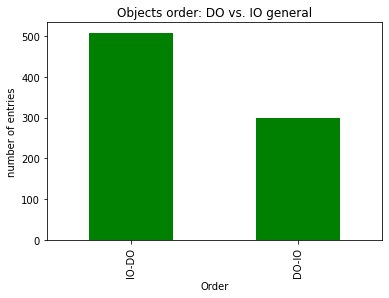

In [11]:
orders['Order_'].value_counts().plot.bar(color='green');
plt.title('Objects order: DO vs. IO general')
plt.xlabel('Order')
plt.ylabel('number of entries');

In [12]:
pd.read_sql_query("SELECT Order_, COUNT(Order_) FROM Verbs GROUP BY Order_", con=conn)

,Order_,COUNT(Order_)
0,DO-IO,300
1,IO-DO,508
2,no,27467


One of the important factors which influence the order of the objects is the POS. If a pronoun occupies one of the objects' positions, it tends to be linearly first. We can see on the plot, that if DO is pronoun, DO-IO order is more frequent, and when DO is a noun, the opposite order occurs more often.

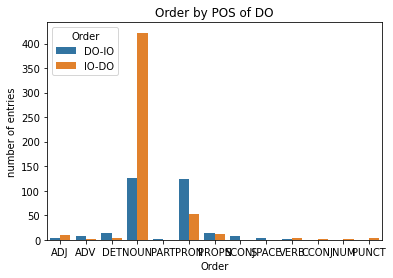

In [13]:
Order_pos = orders[['Order_', 'DO_type','verb']].groupby(['Order_', 'DO_type'], as_index=False).count()

Order_pos.columns = ['Order', 'DO_pos', 'verb']
sns.barplot(x="DO_pos", y="verb", hue='Order', data=Order_pos)
plt.title('Order by POS of DO')
plt.xlabel('Order')
plt.ylabel('number of entries');

The same is true for the IO POS. If IO is a pronoun, IO-DO order is dominant, while noun IOs are more frequent in DO-IO contexts.

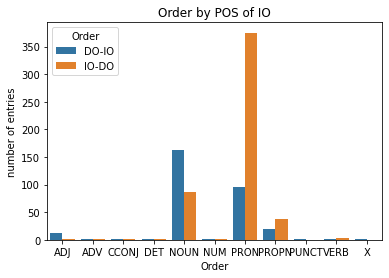

In [14]:
Order_pos = orders[['Order_', 'IO_type','verb']].groupby(['Order_', 'IO_type'], as_index=False).count()

Order_pos.columns = ['Order', 'IO_pos', 'verb']
sns.barplot(x="IO_pos", y="verb", hue='Order', data=Order_pos)
plt.title('Order by POS of IO')
plt.xlabel('Order')
plt.ylabel('number of entries');

Another important influencing factor is animacy - animate objects tend to occupy linearly first place. This is also somehow supported by my data: inanimate DOs are found more often in IO-DO contexts, while inanimate IOs (the plot below) are more often in DO-IO contexts. Although, we can not constate an opposite tendency by animate DOs and IOs. Also, this is the part that lacks statistics the most. 

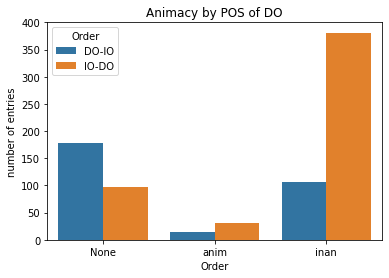

In [15]:
Order_anim = orders[['Order_', 'DO_animacy','verb']].groupby(['Order_', 'DO_animacy'], as_index=False).count()

Order_anim.columns = ['Order', 'DO_animacy', 'verb']
sns.barplot(x="DO_animacy", y="verb", hue='Order', data=Order_anim)
plt.title('Animacy by POS of DO')
plt.xlabel('Order')
plt.ylabel('number of entries');

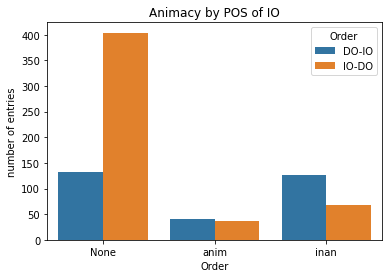

In [16]:
Order_anim = orders[['Order_', 'IO_animacy','verb']].groupby(['Order_', 'IO_animacy'], as_index=False).count()

Order_anim.columns = ['Order', 'IO_animacy', 'verb']
sns.barplot(x="IO_animacy", y="verb", hue='Order', data=Order_anim)
plt.title('Animacy by POS of IO')
plt.xlabel('Order')
plt.ylabel('number of entries');

Thus, the idea of this project was to compare the results of two similar studies on different data (most importantly, manually and auntomatically annotated). Of course, the aim is not fully accomplished, but some theoretical assumption, which are confirmed in the article, are somehow confirmed by my data too

It does not mean at all, that the automatic annotation is satisfying, it has enormous problems in case of Russian at least. But probably in this particular case it was not so significant.